# Branch-category rules

In [1]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/cornershop/venv/lib/python3.9/site-packages')

In [2]:
BASE_DIR = '/Users/efraflores/Desktop/EF/Corner/BR/Surgeries/data/'
STORE_ID = 1481
ACTUAL_RULE = 3

## Entorno

In [3]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.4f}'.format
sorted(os.listdir(BASE_DIR))

['.DS_Store',
 '1327_FR.csv',
 '1327_OOS.csv',
 '1327_actual_00.csv',
 '1327_catalog_01.csv',
 '1327_catalog_02.csv',
 '1327_catalog_03.csv',
 '1327_input.csv',
 '1327_integ_210424.csv',
 '1327_orders_00.csv',
 '1327_supply_01.csv',
 '1327_supply_02.csv',
 '1327_supply_03.csv',
 '1481_FR.csv',
 '1481_OOS.csv',
 '1481_propuesta.csv',
 '1481_summary.csv',
 '5108_FR.csv',
 '5108_OOS.csv',
 '8589_FR.csv',
 '8589_OOS.csv',
 '8589_propuesta.csv',
 '8589_summary.csv',
 '8879_FR.csv',
 '8879_OOS.csv',
 '8879_propuesta.csv',
 '8879_summary.csv',
 'resultado.csv']

## Funciones

In [4]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tono(a = 1000, b = 700, play_time_seconds = 1, framerate = 4410):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

In [5]:
def leer(base_dir,store_id,
         llave=['branch name (branch_id)', 'supply_category',
                'stock_threshold','branch_id'],
         with_0=False):
    fr = pd.read_csv(os.path.join(base_dir,f'{store_id}_FR.csv'))
    oos = pd.read_csv(os.path.join(base_dir,f'{store_id}_OOS.csv'))
    df = oos.merge(fr[llave + ['found_rate_under_threshold','found_rate_above_threshold']],
                   on=llave,how='right').drop_duplicates(subset=llave)
    df = df.sort_values(by=llave[:-1])
    df['total_orders'] = df['orders_under_threshold'] + df['orders_above_threshold']
    df['orders_under_threshold'] = df['orders_under_threshold']/df['total_orders']
    df['products_under_threshold'] = ((df['products_under_threshold'] -
                                       (0 if with_0 else df['products_with_stock_0'])
                                      ) /
                                      (df['total_products'] -
                                       (0 if with_0 else df['products_with_stock_0'])))
    return df

In [6]:
def pivotizar(backup,
              stock='stock_threshold',
              indices=['branch name (branch_id)', 'supply_category',
                       'branch_id', 'total_products','total_orders',
                       'products_with_stock_0'],
              valores=['products_under_threshold',
                       'orders_under_threshold',
                       'found_rate_above_threshold']):
    backup = backup.copy()
    backup[stock] = backup[stock].map(lambda x:str(x).zfill(3))
    for i,valor in enumerate(valores):
        aux = backup.pivot_table(index=indices,
                                 columns=stock,
                                 values=[valor]).fillna(method='ffill',axis=1)
        if i==0: 
            aux = aux.fillna(0)
        else:
            aux = aux.fillna(method='bfill',axis=1)
        aux = aux.join(aux - aux.shift(axis=1).fillna(0), rsuffix='_inc')
        df = aux if i==0 else df.join(aux)
    return df

In [7]:
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)

In [8]:
import string
import warnings
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               #bubble_size=100,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index'))

    #Ahora con sólo dos componentes en PCA para apreciar gráficamente
    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {round(pca.explained_variance_ratio_.sum(),4)}')
    
    #Bubbleplot separando por color cada clúster
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    #size=bubble_size,
                    #sizes=(20,500),
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    #La leyenda estará fuera de la gráfica
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df

In [9]:
import seaborn as sns

def perfilamiento(df,cols=None,cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols==None:
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        for col in aux.columns:
            aux[col] = aux[col]/aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/5))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(),cmap='Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] = aux[columna]/aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

In [10]:
def rules(df,
          orders_th=1, 
          products_th=1,
          peso_fr=15,
          found_rate_col='found_rate',
          orders_col='orders',
          products_col='products',
          m=3):
    
    df = df.copy()
    df.columns = [x+str(y) for x,y in df.columns]
    
    #Crear diccionario con seis columnas: FR,orders,prod y sus increm
    aux_dict = {}
    for col in [found_rate_col,orders_col,products_col]:
        aux_dict[f'{col}_inc'] = df.filter(regex=f'{col}[\S]+inc').head(1).columns.to_list()
        aux_dict[col] = [x for x in df.filter(like=col).head(1).columns 
                         if x not in aux_dict[f'{col}_inc']]
        
    #Para cada renglón se arma un DF con esas 6 columnas
    rule = []
    for row in df.index:
        aux = pd.DataFrame(zip(*[df.loc[row,x] for x in list(aux_dict.values())]),
                           index=[x[-3:] for x in aux_dict[orders_col]], 
                           columns=aux_dict.keys())
        #Reemplazar el incremento inicial porque es el default
        aux.loc['000',aux.filter(like='_inc').head(1).columns] = 0
        #Omitir aquellos stock_thresholds fuera del límite para orders y products
        aux = aux.loc['000':'000',:].append(aux[(aux[orders_col]<orders_th)&
                                         (aux[products_col]<products_th)])
        #Eliminar duplicados de FR (manteniendo la primera aparición) y ordenar descendentemente
        aux = aux.drop_duplicates(subset=[found_rate_col]).sort_values(found_rate_col,0,0)
        aux = aux.reset_index().drop_duplicates(subset=['index']).reset_index(drop=True)
        
        #Omitir stock_thresholds mayores a aquel con el FR máx
        aux = aux[aux['index']<=aux.loc[0,'index']].reset_index(drop=True).copy()
        while len(aux)>0:
            #Si el máx FR es cuando no hay stock_threshold, conservar el cero
            if aux.loc[0,'index']=='000':
                rule.append('000')
                break
            else:
                #Si la diferencia de FR entre el más alto y el stock_threshold=0 es baja,
                inc_fr = (aux.loc[0,found_rate_col]-
                          aux.set_index('index').loc['000',found_rate_col])
                #Y la dif de % products_under dentro del mismo rango de stock_threshold es alta,
                inc_prod = (aux.loc[0,products_col]-
                            aux.set_index('index').loc['000',products_col])
                #Comparar con el peso (decreciente no lineal) a cada punto de FR
                if inc_prod > peso_fr*np.exp(-m*aux.loc[0,products_col])*inc_fr:
                    #Y preservar sólo los stock_thresholds menores al siguiente máximo
                    aux = aux[aux['index']<=aux.loc[1,'index']].copy().reset_index(drop=True)
                else:
                    rule.append(aux.loc[0,'index'])
                    break
    df['rule'] = rule
    return df

In [11]:
def totales(df,rule_col='rule',cluster_col='cluster',omit=False,omit_th=5,export=False):
    aux = []
    for i,x in enumerate(zip(df[rule_col],df[cluster_col])):
        aux_dict = {}
        aux_dict[cluster_col] = x[1]
        aux_dict[rule_col] = x[0]
        for m in ['orders_under','products_under','found_rate_above']:
            aux_dict[m+'_rule'] = df.iloc[i,:].to_frame().loc[f'{m}_threshold{x[0]}',:].values[0]
        aux.append(aux_dict)
    aux = pd.DataFrame(aux,index=df.index)
    for a,y in zip(['actual','inicial'],[str(ACTUAL_RULE).zfill(3),'000']):
        aux[a] = y
        aux = aux.join(df[[x+'threshold'+y for x in 
                           ['orders_under_','products_under_','found_rate_above_']]],
                       lsuffix='_actual',rsuffix='_inicial')
    aux.reset_index(inplace=True)
    if omit:
        aux = aux[aux['total_orders'] > np.percentile(aux['total_orders'],10)].copy()
        aux = aux[aux[rule_col].astype(int) >= omit_th].copy()
    if export: aux.to_csv(os.path.join(BASE_DIR,f'{STORE_ID}_propuesta.csv'),index=False)
    return aux

In [12]:
import operator
from functools import reduce

def summary(df):
    actual = str(ACTUAL_RULE).zfill(3)
    aux_dict = {'index':['orders_under','orders_under_pct',
                         'products_under','products_under_pc','Found_rate_above']}
    aux = df.copy()
    for x in ['000',actual,'rule']:
        aux_list = []
        for m in ['products','orders']:
            pct = aux.filter(regex=fr'^{m}[\w]+{x}$').iloc[:,-1]
            under = pct*aux[f'total_{m}']
            above = (1-pct)*aux[f'total_{m}']
            aux_list.extend([under.sum(),under.sum()/aux[f'total_{m}'].sum()])
        aux_list.append(sum(reduce(operator.mul, col) for col in 
                            zip(aux.filter(regex=fr'^found_[\w]+{x}$').iloc[:,-1],
                                above/above.sum())))    
        aux_dict[x] = aux_list
    aux = pd.DataFrame(aux_dict).rename(columns={'000':'estado inicial',
                                                 actual:f'actual: {ACTUAL_RULE}',
                                                 'rule':'propuesta'}).set_index('index')
    return aux.sort_index()

In [13]:
def summ_cat(df,cols=['branch name (branch_id)','supply_category']):
    summ = pd.DataFrame()
    for col in cols:
        for cat in set(total[col]):
            aux = summary(total[total[col]==cat]).reset_index()
            aux['category'] = cat
            summ = summ.append(aux,ignore_index=True)
    summ['dif'] = summ['propuesta'] - summ[f'actual: {ACTUAL_RULE}']
    summ.to_csv(os.path.join(BASE_DIR,f'{STORE_ID}_summary.csv'),index=False)
    return summ

In [14]:
def example(df,
            orders_th=1, 
            products_th=1,
            peso_fr=15,
            found_rate_col='found_rate',
            orders_col='orders',
            products_col='products',
            m=3):
    
    df = df.copy()
    df.columns = [x+str(y) for x,y in df.columns]
    
    #Crear diccionario con seis columnas: FR,orders,prod y sus increm
    aux_dict = {}
    for col in [found_rate_col,orders_col,products_col]:
        aux_dict[f'{col}_inc'] = df.filter(regex=f'{col}[\S]+inc').head(1).columns.to_list()
        aux_dict[col] = [x for x in df.filter(like=col).head(1).columns 
                         if x not in aux_dict[f'{col}_inc']]
        
    #Para cada renglón se arma un DF con esas 6 columnas
    rule = []
    for row in df.index:
        aux = pd.DataFrame(zip(*[df.loc[row,x] for x in list(aux_dict.values())]),
                           index=[x[-2:] for x in aux_dict[orders_col]], 
                           columns=aux_dict.keys())
        #Reemplazar el incremento inicial porque es el default
        aux.loc['00',aux.filter(like='_inc').head(1).columns] = 0
        
        print('Total branch-category')
        display(aux)
        
        #Omitir aquellos stock_thresholds fuera del límite para orders y products
        aux = aux.loc['00':'00',:].append(aux[(aux[orders_col]<orders_th)&
                                         (aux[products_col]<products_th)])
        #Eliminar duplicados de FR (manteniendo la primera aparición) y ordenar descendentemente
        aux = aux.drop_duplicates(subset=[found_rate_col]).sort_values(found_rate_col,0,0)
        aux.reset_index(inplace = True)#Omitir stock_thresholds mayores a aquel con el FR máx
        aux = aux[aux['index']<=aux.loc[0,'index']].reset_index(drop=True).copy()
        
        print('Sin duplicados (mantiene la 1er aparición) y sin thresholds más altos que aquel con el FR máx')        
        display(aux)
        
        while len(aux)>0:
            #Si el máx FR es cuando no hay stock_threshold, conservar el cero
            if aux.loc[0,'index']=='00':
                rule.append('00')
                break
            else:
                #Si la diferencia de FR entre el más alto y el stock_threshold=0 es baja,
                inc_fr = (aux.loc[0,found_rate_col]-
                          aux.set_index('index').loc['00',found_rate_col])
                #Y la dif de % products_under dentro del mismo rango de stock_threshold es alta,
                inc_prod = (aux.loc[0,products_col]-
                            aux.set_index('index').loc['00',products_col])
                
                display(pd.DataFrame({'Threshold':str(aux.loc[0,'index'])+' --> '+str(aux.loc[1,'index']),
                                     'OOS':aux.loc[0,products_col],'FR':aux.loc[0,found_rate_col],
                                     'Incremento OOS desde estado inicial':inc_prod,
                                     'Incremento FR desde estado inicial':inc_fr,
                                     'Peso unitario para FR según OOS':peso_fr*np.exp(-3*aux.loc[0,products_col]),
                                     'Compara increm OOS vs:':peso_fr*np.exp(-3*aux.loc[0,products_col])*inc_fr},
                                     index=['']).transpose())
                
                #Comparar con el peso (decreciente no lineal) a cada punto de FR
                if inc_prod > peso_fr*np.exp(-m*aux.loc[0,products_col])*inc_fr:
                    #Y preservar sólo los stock_thresholds menores al siguiente máximo
                    aux = aux[aux['index']<=aux.loc[1,'index']].copy().reset_index(drop=True)
                else:
                    rule.append(aux.loc[0,'index'])
                    break
    return f'Se elige el threshold {rule[0]}'

## Ejemplo

aux = pivotizar(percentage(leer(BASE_DIR,STORE_ID)))
aux = aux.loc[('Hiper Aricanduva (6456)', 'seca / especiarias', 6456, 136, 43, 0),:].to_frame().transpose()
aux

aux = pivotizar(percentage(leer(BASE_DIR,STORE_ID)))
aux = aux.iloc[37,:].to_frame().transpose()
aux

example(aux,orders_th=1,products_th=1)

## ETL

In [15]:
backup = leer(BASE_DIR,STORE_ID,with_0=True)
backup.head(2)

,branch name (branch_id),supply_category,branch_id,stock_threshold,key_total_products,key,total_products,products_under_threshold,products_above_threshold,orders_under_threshold,orders_above_threshold,products_with_stock_0,Acumulado without 0,found_rate_under_threshold,found_rate_above_threshold,total_orders
1175,Contagem /BH (8038),C-SALGADINHOS E APERITIVOS,8038,0,Contagem /BH (8038)-C-SALGADINHOS E APERITIVOS,Contagem /BH (8038)-C-SALGADINHOS E APERITIVOS-0,1,1.0000,0,NaN,NaN,1,0.0000,0.6667,NaN,NaN
1324,Contagem /BH (8038),TO_BE_DETERMINED,8038,0,Contagem /BH (8038)-TO_BE_DETERMINED,Contagem /BH (8038)-TO_BE_DETERMINED-0,473,0.0338,457,0.0025,392.0000,16,0.0000,1.0000,0.8061,393.0000


In [16]:
#backup.drop(columns=['key_total_products','key','Acumulado without 0']).to_csv(os.path.join(BASE_DIR,'resultado.csv'),index=False)

In [17]:
df = pivotizar(backup)
df.sample(4)

products_under_threshold  \
stock_threshold                                                                                                                            000   
branch name (branch_id)        supply_category            branch_id total_products total_orders products_with_stock_0                            
Uberlândia (15401)             c-matinais e alim infantil 15401     335            56.0000      13                                      0.0388   
Portão /CWB (7178)             c-derivados de leite       7178      184            58.0000      9                                       0.0489   
Iguatemi /Florianópolis (9611) c-galheteria/conservas     9611      732            127.0000     30                                      0.0410   
Uberlândia (15401)             c-salgadinhos e aperitivos 15401     174            96.0000      6                                       0.0345   

                                                                                                                              \
stock_threshold                                                                                                          003   
branch name (branch_id)        supply_category            branch_id total_products total_orders products_with_stock_0          
Uberlândia (15401)             c-matinais e alim infantil 15401     335            56.0000      13                    0.1224   
Portão /CWB (7178)             c-derivados de leite       7178      184            58.0000      9                     0.1957   
Iguatemi /Florianópolis (9611) c-galheteria/conservas     9611      732            127.0000     30                    0.2664   
Uberlândia (15401)             c-salgadinhos e aperitivos 15401     174            96.0000      6                     0.0632   

                                                                                                                              \
stock_threshold                                                                                                          006   
branch name (branch_id)        supply_category            branch_id total_products total_orders products_with_stock_0          
Uberlândia (15401)             c-matinais e alim infantil 15401     335            56.0000      13                    0.1940   
Portão /CWB (7178)             c-derivados de leite       7178      184            58.0000      9                     0.2935   
Iguatemi /Florianópolis (9611) c-galheteria/conservas     9611      732            127.0000     30                    0.3825   
Uberlândia (15401)             c-salgadinhos e aperitivos 15401     174            96.0000      6                     0.0977   

                                                                                                                              \
stock_threshold                                                                                                          009   
branch name (branch_id)        supply_category            branch_id total_products total_orders products_with_stock_0          
Uberlândia (15401)             c-matinais e alim infantil 15401     335            56.0000      13                    0.2597   
Portão /CWB (7178)             c-derivados de leite       7178      184            58.0000      9                     0.3315   
Iguatemi /Florianópolis (9611) c-galheteria/conservas     9611      732            127.0000     30                    0.4536   
Uberlândia (15401)             c-salgadinhos e aperitivos 15401     174            96.0000      6                     0.1322   

                                                                                                                              \
stock_threshold                                                                                                          012   
branch name (branch_id)        supply_category            branch_id total_products total_orders products_with_stock_0          
Uberlândia (15401)  

## Clustering

### K-óptimo

koptimo(df)

### Gaussian Mixture

Distribución de registros en los 5 clústeres


,index,cluster
3,A,0.0575
1,B,0.3218
0,C,0.4943
4,D,0.0517
2,E,0.0747


Varianza explicada con 2dim: 0.5215


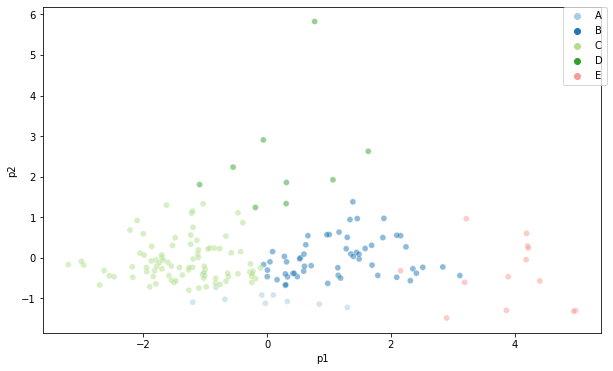

In [18]:
df = clustering(df,df.columns)

### Perfilamiento

<Figure size 432x288 with 0 Axes>

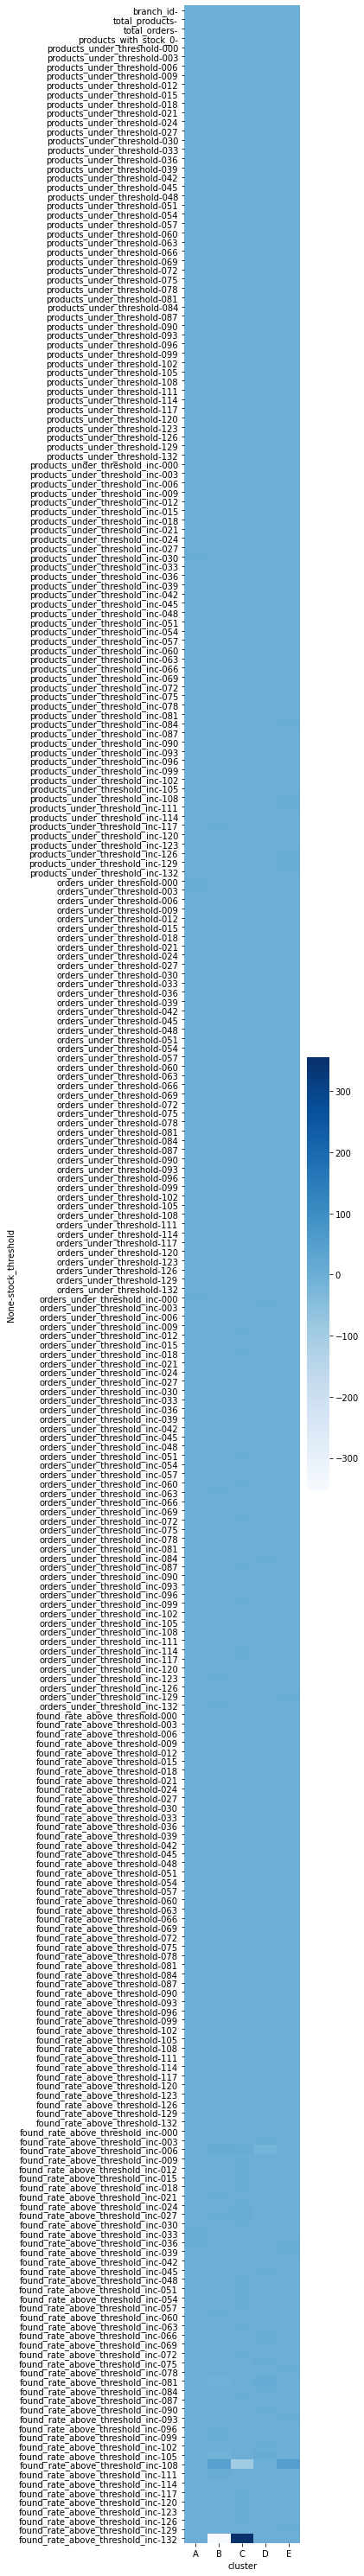

In [19]:
perfilamiento(df.reset_index())

<Figure size 432x288 with 0 Axes>

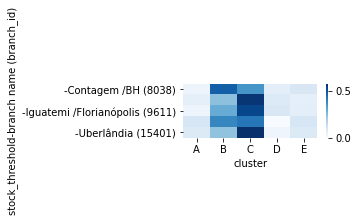

<Figure size 432x288 with 0 Axes>

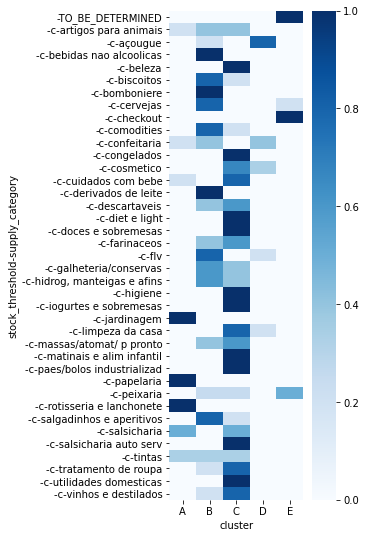

In [20]:
perfilamiento(df.reset_index(),cols = ['branch name (branch_id)', 'supply_category'])

## Rules

In [21]:
df = rules(df,products_th=0.4)
df['rule'].value_counts(1)

000   0.9080
009   0.0345
015   0.0115
012   0.0115
021   0.0115
003   0.0057
006   0.0057
036   0.0057
129   0.0057
Name: rule, dtype: float64

In [22]:
cm = sns.light_palette('LightSkyBlue', as_cmap=True)
df.pivot_table(index='rule',
               columns='cluster',
               values=df.columns[0],
               aggfunc='count',
               fill_value=0).iloc[1:,:].style.background_gradient(cmap=cm).format('{:.0f}')

cluster,A,B,C,D,E
rule,,,,,
003,0,0,1,0,0
006,0,0,1,0,0
009,0,2,4,0,0
012,0,0,1,0,1
015,0,2,0,0,0
021,0,2,0,0,0
036,0,0,0,0,1
129,0,0,0,0,1


In [23]:
aux = df.copy()
aux['rule'] = aux['rule'].astype(int)
aux = aux[aux['rule']>0].copy()
aux.groupby('cluster')['rule'].agg(['median','count','mean',lambda x:np.percentile(x,40)]
                                  ).style.background_gradient(cmap=cm).format('{:.1f}')

,median,count,mean,
cluster,,,,
B,15.0,6.0,15.0,15.0
C,9.0,7.0,8.1,9.0
E,36.0,3.0,59.0,31.2


## Summary

In [24]:
summary(totales(df))

,estado inicial,actual: 3,propuesta
index,,,
Found_rate_above,0.8136,0.8126,0.8160
orders_under,2873.0000,9151.0000,4026.0000
orders_under_pct,0.0446,0.1421,0.0625
products_under,1157.0000,1570.0000,1331.0000
products_under_pc,0.0491,0.0666,0.0565


In [25]:
total = totales(df,omit=True,export=True)
total.sample(4)

,branch name (branch_id),supply_category,branch_id,total_products,total_orders,products_with_stock_0,cluster,rule,orders_under_rule,products_under_rule,found_rate_above_rule,actual,orders_under_threshold003,products_under_threshold003,found_rate_above_threshold003,inicial,orders_under_threshold000,products_under_threshold000,found_rate_above_threshold000
141,Uberlândia (15401),c-biscoitos,15401,379,194.0000,27,B,009,0.1443,0.2005,0.8855,003,0.0567,0.1398,0.8579,000,0.0464,0.0712,0.8595
145,Uberlândia (15401),c-comodities,15401,495,209.0000,33,C,009,0.1292,0.2303,0.9066,003,0.0861,0.1192,0.8796,000,0.0478,0.0667,0.8844
8,Contagem /BH (8038),c-checkout,8038,67,9.0000,0,E,129,0.4444,0.3134,1.0000,003,0.1111,0.0000,0.8750,000,0.1111,0.0000,0.8750
5,Contagem /BH (8038),c-biscoitos,8038,429,132.0000,30,B,021,0.2273,0.3963,0.9020,003,0.0152,0.1911,0.8077,000,0.0076,0.0699,0.8092


In [26]:
summary(total)

,estado inicial,actual: 3,propuesta
index,,,
Found_rate_above,0.8528,0.8526,0.8961
orders_under,217.0000,562.0000,1340.0000
orders_under_pct,0.0465,0.1204,0.2872
products_under,71.0000,87.0000,238.0000
products_under_pc,0.0448,0.0549,0.1501


In [27]:
summ = summ_cat(total)
summ.sample(4)

,index,estado inicial,actual: 3,propuesta,category,dif
56,orders_under,115.0000,242.0000,468.0000,c-biscoitos,226.0000
3,products_under,34.0000,45.0000,92.0000,Uberlândia (15401),47.0000
36,orders_under,0.0000,0.0000,39.0000,c-checkout,39.0000
6,orders_under,33.0000,61.0000,252.0000,Portão /CWB (7178),191.0000


## Fin

In [28]:
time_exp(time.time() - start)
tono()

0 minutos con 14.23 segundos
